<a href="https://colab.research.google.com/github/SoniyaKoduru/Bigdata-driving-Sustainable-Supply-Chain-Management/blob/main/690_HM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                              review  label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1

 (1000, 2)

Vocabulary length: 2536

Encoded Reviews Sample:
Review 1: [381, 2173, 129, 2026, 1502, 1945, 1019, 2025, 1144, 952, 1166, 1685, 1166, 101, 1376, 1281, 2114, 2301, 1152, 301, 0]
Review 2: [1069, 676, 2266, 337]
Review 3: [1184, 1945, 101, 1009]
Review 4: [0, 2025, 715, 1945, 2343, 1039, 52, 1906, 2366, 1356, 2451, 452]
Review 5: [101, 1107, 129, 1184]

Epoch 0, Loss: 0.7002595383673906, Accuracy: 0.47

Epoch 1, Loss: 0.6929956413805485, Accuracy: 0.508

Epoch 2, Loss: 0.6900371108204126, Accuracy: 0.528

Epoch 3, Loss: 0.6953361332416534, Accuracy: 0.495

Epoch 4, Loss: 0.6841754764318466, Accuracy: 0.542

Epoch 5, Loss

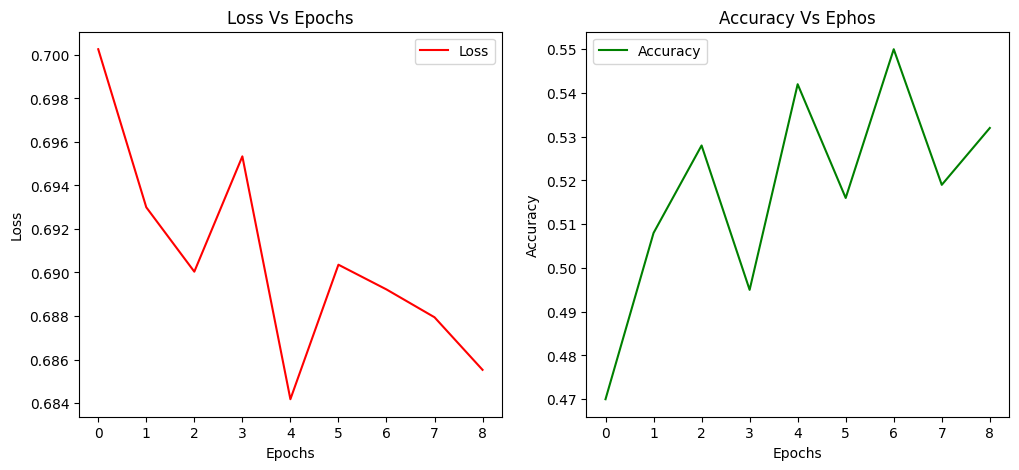

In [110]:
### EXERCISE 1  ###

!pip install torch torchvision torchaudio
!pip install textblob

# 1.Importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# 2 & 3 : Loading the data from the given site and converting to columns and removing punctuations from reviews column

# Loading the amazon reviews (1000) data from the given url
file_path = 'amazon_cells_labelled.txt'
data = pd.read_csv(file_path,delimiter='\t',header=None, names=['review','label'])
print(data.head())   # getting the glimpse of loaded data

# Restricting the data to 1000 reviews
data = data.head(1000)

# printing size of the data
print("\n",data.shape)

reviews = data['review'].str.lower()    # avoiding error for same words
labels = data['label']

# Defining function to remove punctuation using regex

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]'," ", text)                        # removing punctuation & special characters ( \w : alphanumeric & \s white space)
    text = re.sub(r'\s+', " ", text)                           # Replacing multiple spaces with a single space
    return text.strip()

reviews = reviews.apply(remove_punctuation)                # removing punctuations

# 4.Creating vocabulary of the all the reviews
words = ''.join(reviews).split()                           # Joining all the reviews to get the words
vocab = set(words)                                             # getting the unique words avoiding duplicacy
print("\nVocabulary length:",len(vocab))

# 5.Creating dictionary of words mapping each word to an integer
word_dict = {}                                                 # Creating a dictionary to store the word and its integer
for i,word in enumerate(vocab):
    word_dict[word] = i

# 6.Encoding the review data by replacing each word in a review for its paired integer
encoded_reviews = []                                                      # defining the list to store the repective integers
for review in reviews:
    encoded_review = [word_dict.get(word,0) for word in review.split()]    # splitting the words of each line and mapping the respective integer
    encoded_reviews.append(encoded_review)

# padding the reviews so that the length of all the reviews are same
max_len = max(len(review) for review in encoded_reviews)                 # Identifying maximum length
padded_reviews = np.array([np.pad(review, (0, max_len - len(review)), 'constant') for review in encoded_reviews])   # ensuring the same length reviews

# Displaying few encoded reviews
print("\nEncoded Reviews Sample:")
for i in range(5):
    print(f"Review {i+1}: {encoded_reviews[i]}")

# 7.Creating a class containing the architecture of the network

# Defining RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        return self.sigmoid(self.fc(x[:, -1, :]))

# 8. Model initialization and training the parameters
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
output_dim = 1
n_layers = 2

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

# Using binary cross-entropy loss since it is binary classification
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 9

# parameters are set by trial and error method avoiding overfitting and ensuring lower loss and high accuaracy

# 9. Convert to tensors and create DataLoader
reviews_tensor = torch.tensor(padded_reviews, dtype=torch.long)
labels_tensor = torch.tensor(data['label'].values, dtype=torch.float32)
dataset = TensorDataset(reviews_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 10. Training loop
losses = []
accuracies = []

for epoch in range(n_epochs):
    total_loss = 0
    correct = 0

    for reviews_batch, labels_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(reviews_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.round(outputs.squeeze())
        correct += (predicted == labels_batch).sum().item()

    accuracy = correct / len(labels_tensor)
    losses.append(total_loss / len(dataloader))
    accuracies.append(accuracy)

    print(f'\nEpoch {epoch}, Loss: {total_loss / len(dataloader)}, Accuracy: {accuracy}')

# 11. Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), losses, label="Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), accuracies, label="Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Ephos')
plt.legend()

plt.show()

In [108]:
### EXERCISE 2  ###

# Sentiment analysis of given text

given_text = """
The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on -
road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines ,
and crawling across boulder-strewn trials.
"""

!pip install textblob
# importing required libraries

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# 1.replacing special characters with empty space  ( text_nsc : text with no special characters)
def remove_specialchar(text):
    return re.sub(r'[^A-Za-z0-9\s]', ' ', text)        # \w : alphanumeric , \s : white space character
text_nsc = remove_specialchar(given_text)
print("\nText after removing special characters:\n",text_nsc)

# 2.removing multiple empty spaces and replacing them with a single space
def remove_multiple_space(text):
    return re.sub(r'\s+',' ',text)            # \s+ : more than 1 space character

text_nms = remove_multiple_space(text_nsc)
print("\nText after removing multiple spaces:\n",text_nms)

# 3.Remove any single character
def remove_singlechar(text):
    return  re.sub(r'\b\w\b',' ',text)        # remvoing single characters

text_nsic = remove_multiple_space(remove_singlechar(text_nms))   # removing both single char & also multiple spaces
print("\nText after removing single characters:\n",text_nsic)

# 4. Converting the text to all lowercase
text_lc = text_nsic.lower()
print("\nLowercase text\n",text_lc)

# 5.Split the text into individual words using tokenization
words = word_tokenize(text_lc)
print("\nlength of words:",len(words))

# 6.removing stopwords
stop_words = set(stopwords.words('english'))      # Extracting stopwords from nltk of english language

filtered_words = []
for word in words:
    if word not in stop_words:
      filtered_words.append(word)
print("length of filtered words:",len(filtered_words))

# 7.Tokenize, stem, and lemmatize the text

# stemming
stemmer = PorterStemmer()                 # choosing porter stemmer because of its simplicity

stemmed_words = []
for word in filtered_words:
    stemmed_word = stemmer.stem(word)
    stemmed_words.append(stemmed_word)
print("\nStemmed text:\n",' '.join(stemmed_words))     # joining all the words back to text

# Lemmatization
lemmatizer = WordNetLemmatizer()

lemmatized_words = []
for word in filtered_words:
    lemmatized_word = lemmatizer.lemmatize(word)
    lemmatized_words.append(lemmatized_word)
lemmatized_text = ' '.join(lemmatized_words)          # joining all the words back to text
print("\nlemmatised text:\n",lemmatized_text)

# 8. Finding overall sentiment and subjectivity of the given text

# using textblob for analysing the sentiment
blob = TextBlob(lemmatized_text)     # choosing lemmatized text for accurate words
sentiment = blob.sentiment

# Sentiment classification
def sentiment_label(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

print("\nOverall sentiment:",sentiment_label(sentiment.polarity))
print("Sentiment Polarity:", sentiment.polarity)
print("Sentiment Subjectivity:", sentiment.subjectivity)



Text after removing special characters:
 
The larger Broncos will be available with 35 inch off road tires and will be able
to drive through water nearly 3 feet  10 inches deep  It has independent front suspension  unlike its main competitor  the Jeep Wrangler  Independent suspension  used
on almost all modern passenger vehicles  generally provides a smoother ride and better on  
road handling than a single solid axle  It still has a solid axle in the back though  like most
pickup trucks  a design suited to hard use  Like the Wrangler  both the two  and four door
Bronco will have a removable roofs and doors  Buyers will be able to choose either a hard
roof that can be removed in sections  a cloth top  or both  Unlike the Wrangler  though  the
Bronco s doors will fit inside the vehicle after being removed  The Bronco will be available
with a choice of either a 10 speed automatic or seven speed manual transmission   The
manual transmission will have six gears for ordinary driving  plus 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
